### Ноутбук содержит реализацию посчёта shap для дерева решений

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from lightgbm import LGBMClassifier

from collections import Counter

In [85]:
import graphviz
import math
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

# conda install python-graphviz
# conda install -c conda-forge shap
import shap

In [120]:
class ShapCustom():
    def __init__(self):
        pass
        
    def get_value_from_set(self, set_of_feats, model):
        """
            проходим по дереву и определяем куда попадает объект если заданы не все признаки, если вариантов несколько, 
            то усредняем с нормировкой на вероятность попадания в лист
        """
        val = []
        index_to_process = [[0, 1]]
        ind = 0
        p_curr = 1
        samples_sum = 0
        while len(index_to_process) > 0:
            if model.tree_.feature[ind] == -2:
                val.append(model.tree_.value[ind, 0, 0] * p_curr)  # * model.tree_.n_node_samples[ind]
                # samples_sum += model.tree_.n_node_samples[ind]
            elif model.tree_.feature[ind] in set_of_feats:
                if set_of_feats[model.tree_.feature[ind]] > model.tree_.threshold[ind]:
                    index_to_process.append([model.tree_.children_right[ind], p_curr])
                else:
                    index_to_process.append([model.tree_.children_left[ind], p_curr])
            else:
                ind_next_r = model.tree_.children_right[ind]
                p_right = (model.tree_.n_node_samples[ind_next_r] / model.tree_.n_node_samples[ind]) * p_curr

                ind_next_l = model.tree_.children_left[ind]
                p_left = (model.tree_.n_node_samples[ind_next_l] / model.tree_.n_node_samples[ind]) * p_curr

                index_to_process.append([ind_next_r, p_right])
                index_to_process.append([ind_next_l, p_left])
            # print(ind, index_to_process)
            index_to_process.remove([ind, p_curr])
            if index_to_process:

                ind = index_to_process[-1][0]
                p_curr = index_to_process[-1][1]
        return np.sum(val)#/ samples_sum#np.mean(val)

    def get_shap_values(self, model, X):
        
        shap_full = []
        X = np.array(X)
        sample_len, len_per_sample = X.shape[0], X.shape[1]
        for i in tqdm(range(sample_len)):
            X_sample = X[i, :]
            shap_per_sample = []
            for j in range(len_per_sample):
                index_val_full = dict(enumerate(X_sample))
                rest = np.array(list(range(0, j)) + list(range(j+1, len_per_sample)))
                include_feats = np.array([False] * len(rest))
                feature_shap = 0
                for _ in range(2 ** len(rest)):
                    index_val_temp = dict()
                    for ind in rest[include_feats]:
                        index_val_temp[ind] = index_val_full[ind]
                    value_wo = self.get_value_from_set(index_val_temp, model)
                    # print(index_val_temp, value_wo)
                    index_val_temp[j] = index_val_full[j]
                    value_w = self.get_value_from_set(index_val_temp, model)
                    # print(index_val_temp, value_w)
                    s, f = len(index_val_temp)-1, len_per_sample
                    coef = (math.factorial(s) * math.factorial(f-s-1)) / math.factorial(f)
                    feature_shap += coef * (value_w - value_wo)
                    # print(s, f, coef, feature_shap)/
                    check_ind = -1
                    while -check_ind <= len(include_feats):
                        if not include_feats[check_ind]:
                            include_feats[check_ind] = True
                            break
                        else:
                            include_feats[check_ind] = False
                        check_ind -= 1
                shap_per_sample.append(feature_shap)
            shap_full.append(shap_per_sample.copy())
        return pd.DataFrame(shap_full, columns=['f' + str(i) for i in range(len_per_sample)])

sc = ShapCustom()

In [122]:
df = (
    pd.read_csv("../data/cs-training.csv")
    .drop(columns='Unnamed: 0')
    .rename(columns={'SeriousDlqin2yrs': 'target'})
)
features = [f for f in df.columns if f not in ('target', 'id')]
df['segment2'] = np.random.choice([f'seg{i}' for i in range(15)], df.shape[0])
df.shape

(150000, 12)

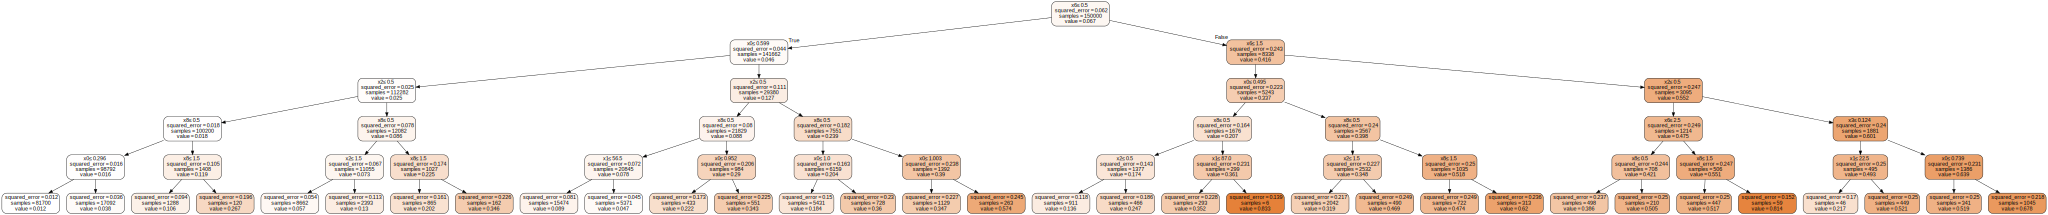

In [171]:
model = DecisionTreeRegressor(max_depth=5)
model.fit(df[features], df['target'])
dot_data = export_graphviz(model, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [173]:
res1 = pd.DataFrame(shap.TreeExplainer(model).shap_values(df[features][:1000]), columns=['f' + str(i) for i in range(len(features))])
res1

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0.057340,0.001847,0.093303,0.000301,0.0,0.0,-0.019511,0.0,-0.016545,0.0
1,0.065168,0.005796,-0.020440,-0.000459,0.0,0.0,-0.017784,0.0,-0.009744,0.0
2,0.057471,0.001074,0.022754,-0.000519,0.0,0.0,0.204622,0.0,-0.032947,0.0
3,-0.023811,0.000927,-0.010664,-0.000336,0.0,0.0,-0.016741,0.0,-0.004121,0.0
4,0.084406,0.001925,0.065308,-0.000844,0.0,0.0,-0.016510,0.0,-0.017550,0.0
...,...,...,...,...,...,...,...,...,...,...
995,-0.019263,0.000549,0.036925,0.000185,0.0,0.0,-0.017651,0.0,-0.010554,0.0
996,-0.030104,0.000549,0.048026,0.000185,0.0,0.0,-0.017860,0.0,-0.010606,0.0
997,0.106414,-0.002900,0.051316,0.000301,0.0,0.0,-0.015974,0.0,0.141212,0.0
998,-0.023937,0.000897,-0.010815,0.000120,0.0,0.0,-0.016892,0.0,-0.004121,0.0


In [175]:
res2 = sc.get_shap_values(model, df[features][:1000])
res2

100%|██████████| 1000/1000 [10:58<00:00,  1.52it/s] 


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
0,0.057340,0.001847,0.093303,0.000301,0.0,0.0,-0.019511,0.0,-0.016545,0.0
1,0.065168,0.005796,-0.020440,-0.000459,0.0,0.0,-0.017784,0.0,-0.009744,0.0
2,0.057471,0.001074,0.022754,-0.000519,0.0,0.0,0.204622,0.0,-0.032947,0.0
3,-0.023811,0.000927,-0.010664,-0.000336,0.0,0.0,-0.016741,0.0,-0.004121,0.0
4,0.084406,0.001925,0.065308,-0.000844,0.0,0.0,-0.016510,0.0,-0.017550,0.0
...,...,...,...,...,...,...,...,...,...,...
995,-0.019263,0.000549,0.036925,0.000185,0.0,0.0,-0.017651,0.0,-0.010554,0.0
996,-0.030104,0.000549,0.048026,0.000185,0.0,0.0,-0.017860,0.0,-0.010606,0.0
997,0.106414,-0.002900,0.051316,0.000301,0.0,0.0,-0.015974,0.0,0.141212,0.0
998,-0.023937,0.000897,-0.010815,0.000120,0.0,0.0,-0.016892,0.0,-0.004121,0.0


Алгоритм получился очень медленным, его можно оптимизировать, но в данном ноутбуке упор сделан на понимание принципа работы shap, поэтому я решил не тратить время на оптимизацию.

In [177]:
(res1 == res2).mean()

f0    0.013
f1    0.003
f2    0.017
f3    0.001
f4    1.000
f5    1.000
f6    0.002
f7    1.000
f8    0.017
f9    1.000
dtype: float64

In [187]:
(res1 - res2).max()

f0    2.775558e-16
f1    1.387779e-17
f2    2.775558e-16
f3    2.428613e-17
f4    0.000000e+00
f5    0.000000e+00
f6    1.554312e-15
f7    0.000000e+00
f8    7.216450e-16
f9    0.000000e+00
dtype: float64

In [189]:
pd.concat([
    res2.abs().mean(),
    res1.abs().mean()
], axis=1)


,0,1
f0,0.031228,0.031228
f1,0.002535,0.002535
f2,0.022347,0.022347
f3,0.000403,0.000403
f4,0.000000,0.000000
f5,0.000000,0.000000
f6,0.031416,0.031416
f7,0.000000,0.000000
f8,0.011598,0.011598
f9,0.000000,0.000000
